In [1]:
import time
import math
import numpy as np
from problems import fourth_order
from pinn import PINN, make_points
from plots_and_stats import plot_errors, plot_comparison
np.random.seed(1234)

a1 = 1.000, a2 = 2.000, a3 = -1.000, a4 = 0.500,
 b1 = -12.760, b2 = 59.682, b3 = -120.000, b4 = 52.500


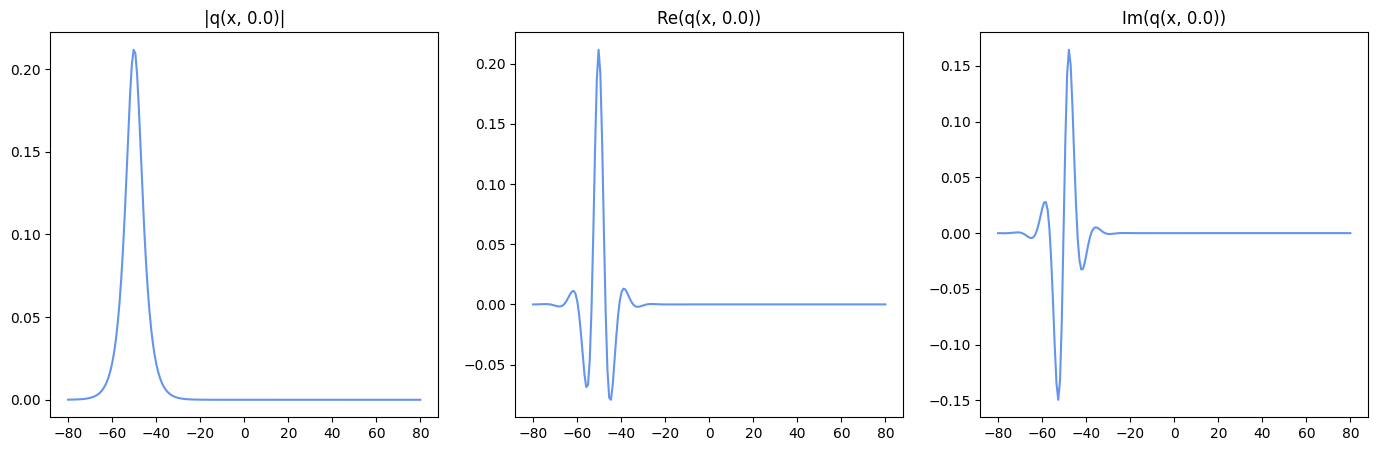

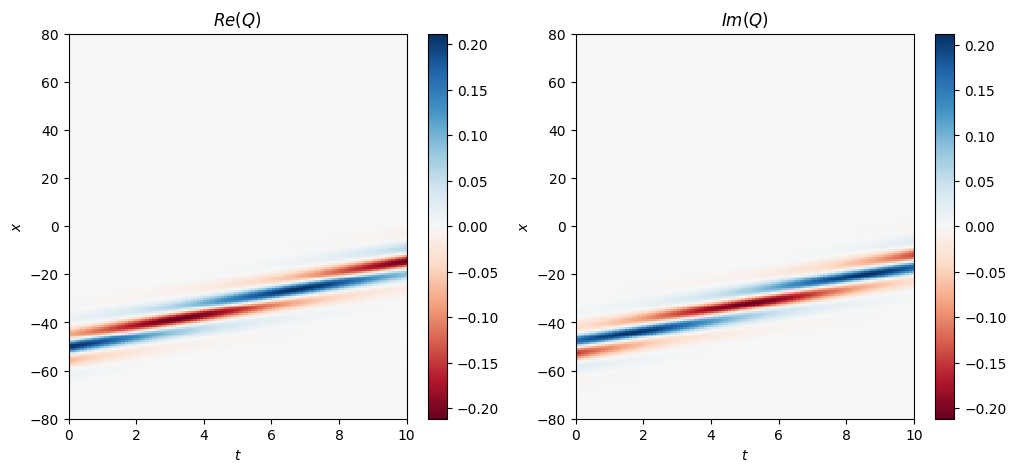

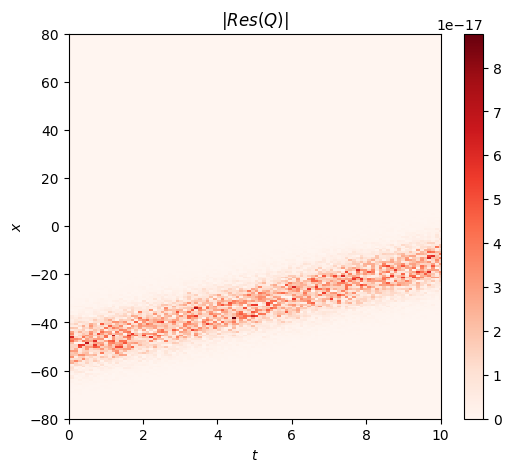

In [2]:
#domain setting
x_0=-80.
x_1=80.
t_0=0.
t_1=10.
#problem setting
a1 = 1.
a2 = 2.
a4 = 0.5
A_param = 1.
k_param = 0.5
nu = 0.088
mu = -2.
x0_param = -50.
theta0 = 0.
problem = fourth_order(x_0, x_1, t_0, t_1, a1, a2, a4, A_param, k_param, nu, mu, x0_param, theta0)
#info about the problem
problem.show_params()
problem.show_ic(x_resolution=200)
problem.show_solution(x_resolution=200, t_resolution=100, show_residual=True)

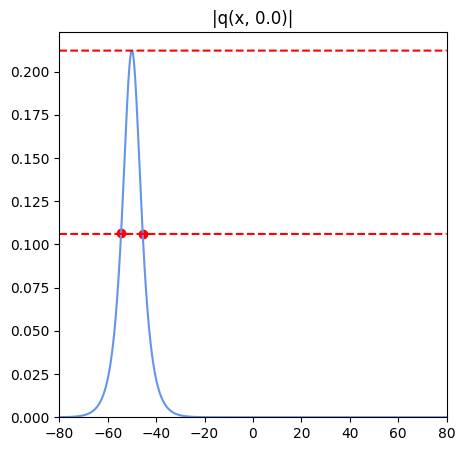

8.93023255813953

In [3]:
problem.find_half_width(eps=0.001)

In [4]:
#data for training
X_i_train, U_i_train, V_i_train, X_b_train, X_grid = make_points(problem, init_points_amt=400, bound_points_amt=100, grid_resolution_x=200, grid_resolution_t=100)
#data for metrics evaluation
x_parts=200
t_parts=100
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #test input for PINN
Q_truth=problem.q(X,T) #ground truth
layers = [2, 100, 100, 100, 2] #network topology

In [ ]:
%%time
model = PINN(problem, layers, X_i_train, U_i_train, V_i_train, X_b_train, X_grid)
##Setting hyperparameters
#verbosity
model.verbosity = 10000 #loss output frequency
model.make_res_gif = False #makes gif with residual history
#points generation options
model.points_gen_method = "second" #"random"/first"/"second"/"third"
model.points_gen_freq = 10 #points generation frequency
model.points_am = 5000 #amount of collocation points
#optimization options
model.adam_steps = 200000
model.lbfgs_steps = 1000
model.nncg_steps = 0
model.adam_step_decay = 0.999 #0.998
model.lbfgs_step_decay = 0.990
model.nncg_step_decay = 0.990
model.decay_freq = 100
#loss balancing options
model.loss_bal_method = "relobralo" #"none"/"relobralo"
model.bal_freq = 1000 #loss rebalancing frequency
model.lambda_i = 950/1000
model.lambda_b = 49/1000
model.lambda_f = 1/1000
model.extinction = 0.0 #extinction coefficient for ReLoBRaLo
#causal training
model.causal_loss = True
model.epsilon = 0.80
model.t_partition = 50 #number of parts in the [t_0, t_1] division

model.train()

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
torch.save(model, f'model(4th_order).pth')
#model = torch.load(f'model(4th_order).pth', map_location=device)

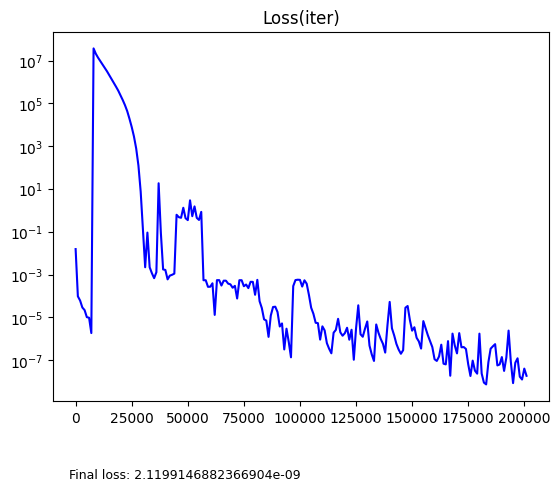

In [6]:
model.train_hist(logscale=True, step=1000)

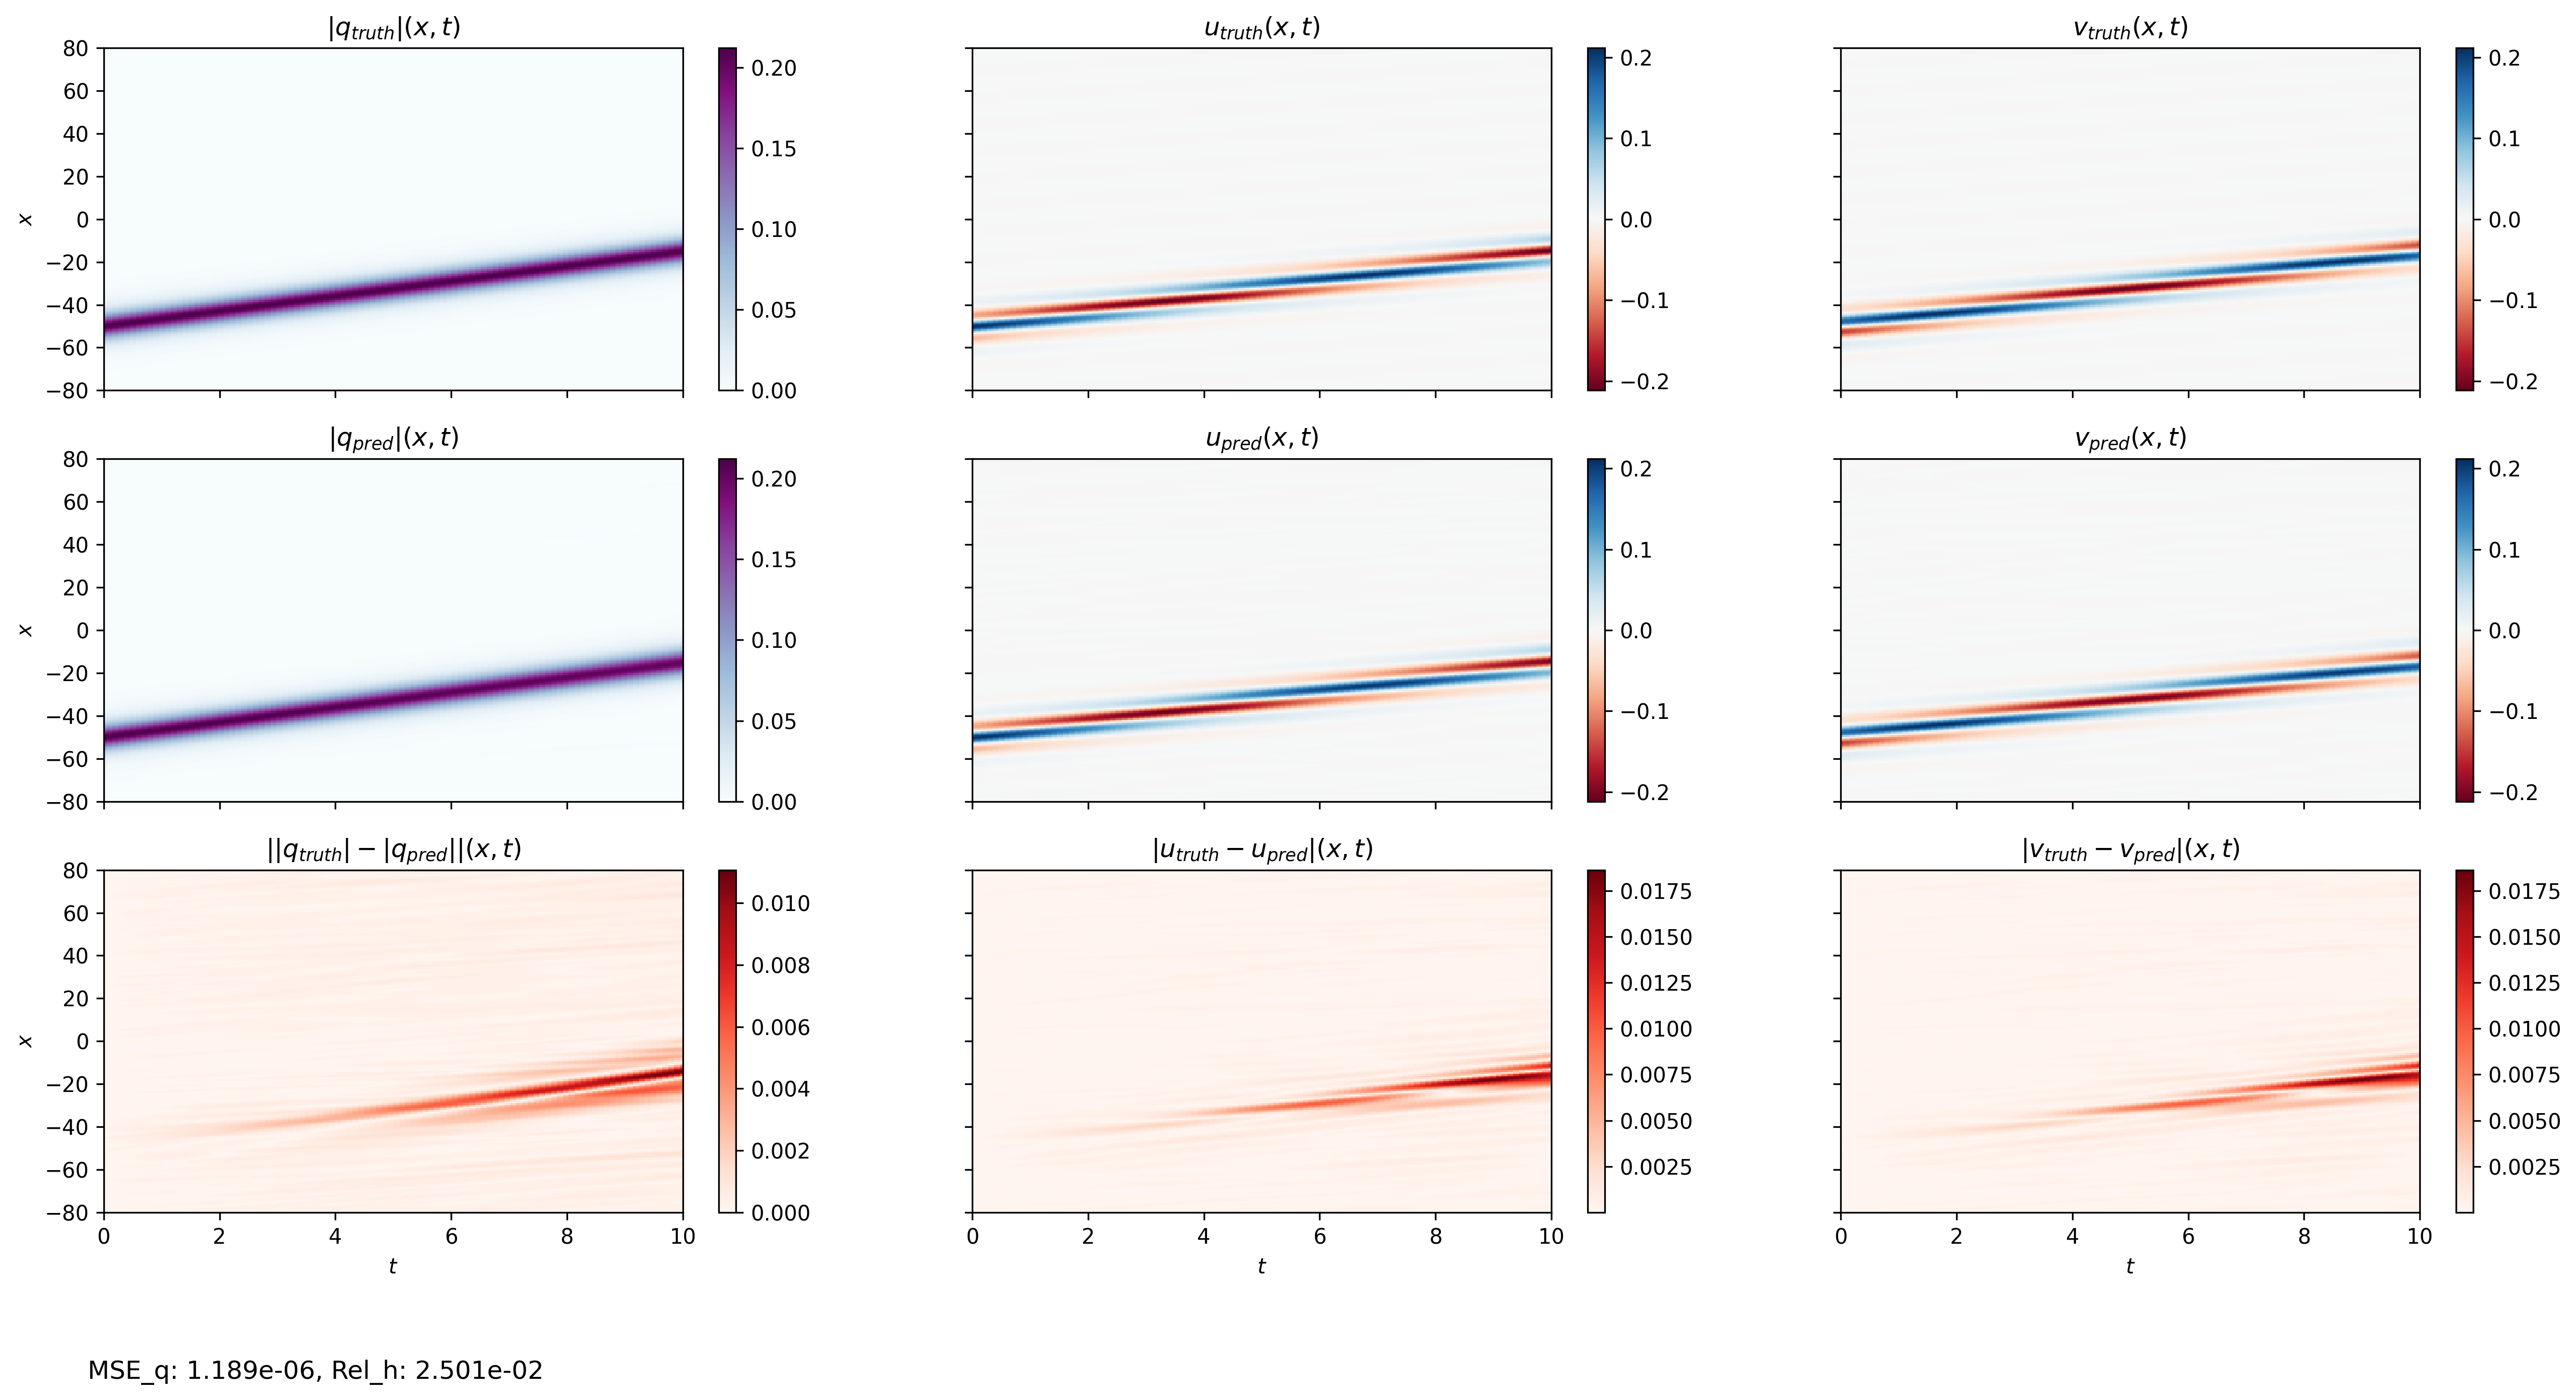

{'MSE_q': 1.1894923746414886e-06, 'Rel_h': 0.025008180169675695}

In [7]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
Q_pred=u_pred.reshape((t_parts, x_parts)) + 1j*v_pred.reshape((t_parts, x_parts))
plot_comparison(X, T, Q_pred, Q_truth, savefig=False, namefig="test_comparison(4th_order).png")

Dimensionality by x: 200, by t: 100


{'Lw1_per_max': 3.0709724518171453,
 'Lw1_per_mean': 2.121327069661874,
 'Lw2_per_max': 3.5617286345401102,
 'Lw2_per_mean': 2.390288071254785,
 'Rel_h': 0.025008180169675695}

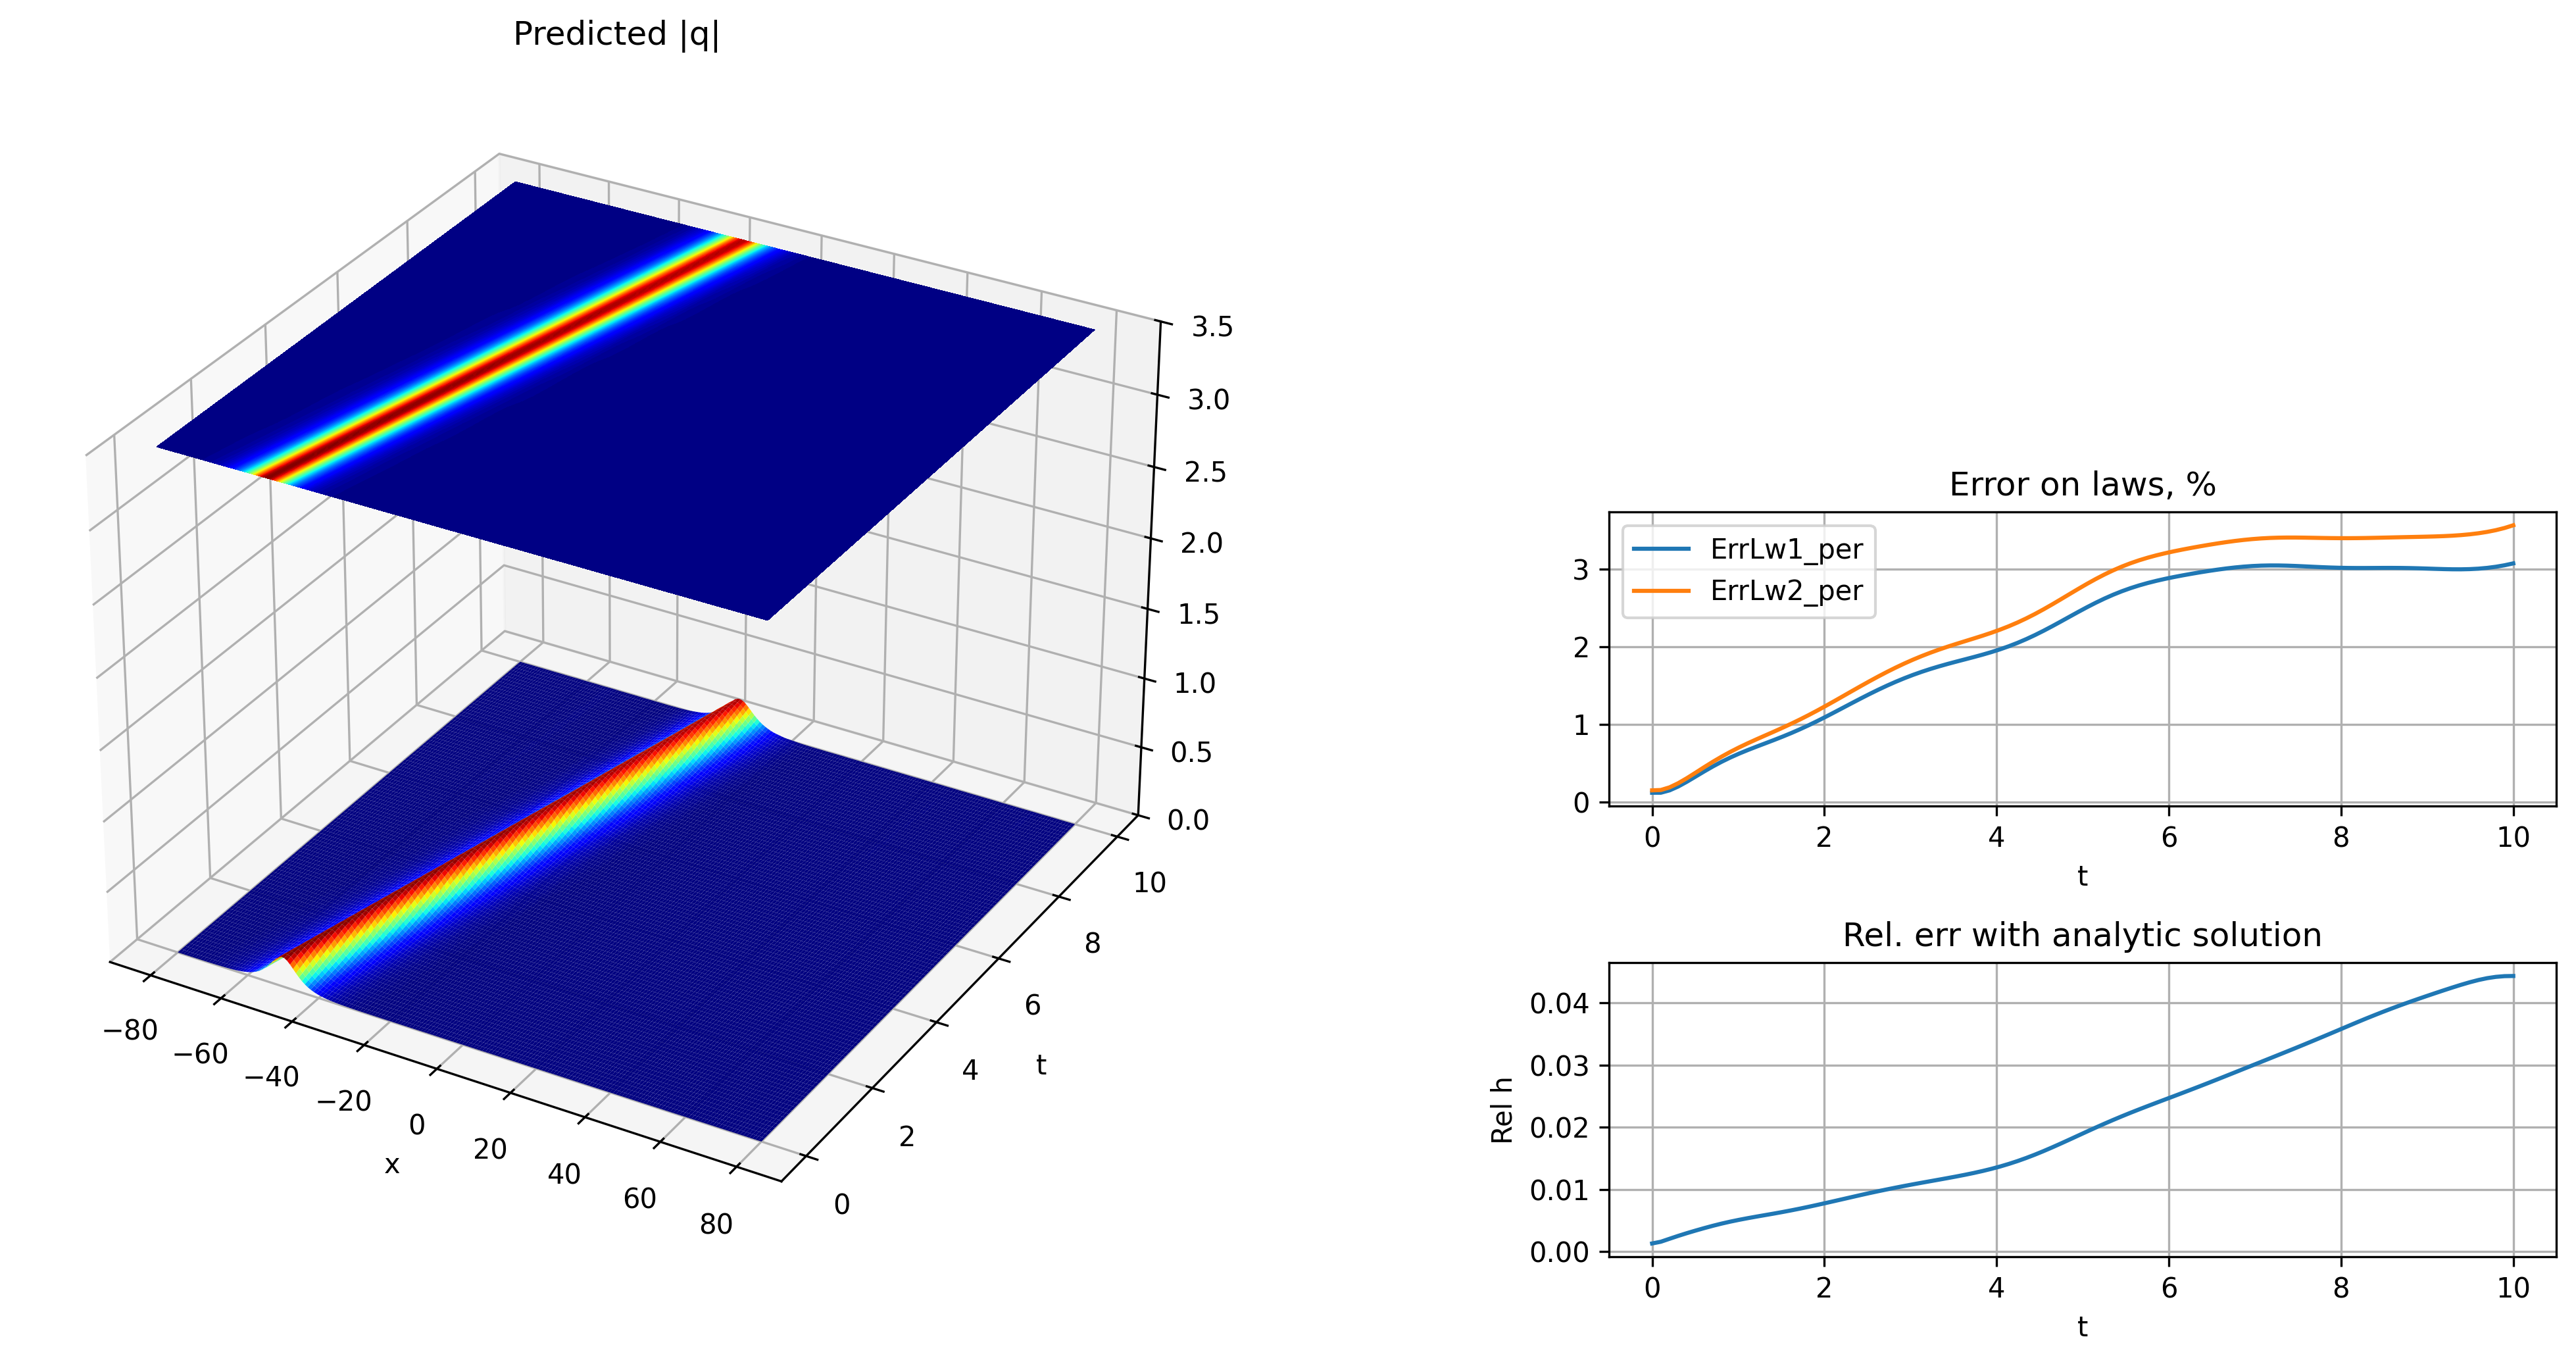

In [8]:
plot_errors(X, T, Q_pred, Q_truth, savefig=False, namefig="test_errors(4th_order).png", savetable=False, nametable="data(4th_order).csv")

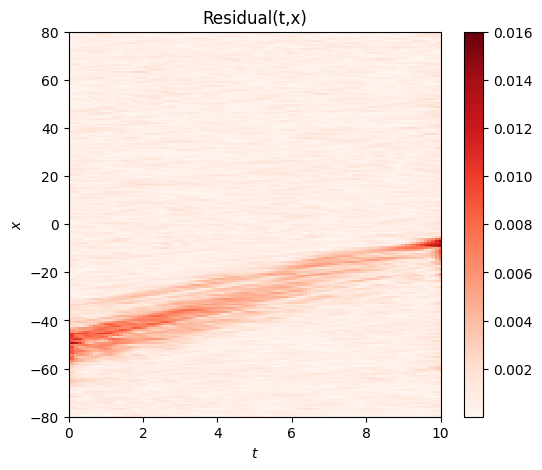

In [17]:
model.plot_residual(X, T)